# GNN Decoder for BCH Codes

This notebook reproduces the (63,45) BCH results in the paper [Graph Neural Networks for Channel Decoding](https://arxiv.org/pdf/2207.14742.pdf).

**Remark**: the training can take several hours. However, pre-trained weights are stored in this repository and can be directly loaded to reproduce the results.

This notebook requires [Sionna](https://nvlabs.github.io/sionna/).

In [1]:
# general imports
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# load required Sionna components
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder

%load_ext autoreload
%autoreload 2
from gnn import * # load GNN functions
from wbp import * # load weighted BP functions

2022-12-02 12:31:31.281111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 12:31:31.464839: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-02 12:31:31.519439: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-02 12:31:32.558832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 8
Only GPU number 0 used.


## Define Hyperparameters and Load Code

We define all parameters as dictionary to support different architectures for different codes.


In [3]:
#----- BCH -----
params={
    # --- Code Parameters ---
        "code": "BCH", # (63,45)
    # --- GNN Architecture ----
        "num_embed_dims": 20,
        "num_msg_dims": 20,
        "num_hidden_units": 40,
        "num_mlp_layers": 2,
        "num_iter": 8,
        "reduce_op": "mean",
        "activation": "tanh",
        "clip_llr_to": None,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "use_bias": False,        
    # --- Training ---- # 
        "batch_size": [256, 256, 256], # bs, iter, lr must have same dim
        "train_iter": [35000, 300000, 300000],
        "learning_rate": [1e-3, 1e-4, 1e-5],
        "ebno_db_train": [3, 8.],
        "ebno_db_eval": 4.,          
        "batch_size_eval": 10000, # batch size only used for evaluation during training
        "eval_train_steps": 1000, # evaluate model every N iters
    # --- Log ----
        "save_weights_iter": 10000, # save weights every X iters
        "run_name": "BCH_01", # name of the stored weights/logs
        "save_dir": "results/", # folder to store results
    # --- MC Simulation parameters ----
        "mc_iters": 1000,
        "mc_batch_size": 2000,
        "num_target_block_errors": 500,
        "ebno_db_min": 2.,
        "ebno_db_max": 9.,
        "ebno_db_stepsize": 1.,
        "eval_iters": [2, 3, 4, 6, 8, 10],        
    # --- Weighted BP parameters ----
        "simulate_wbp": True, # simulate weighted BP as baseline
        "wbp_batch_size" : [2000, 2000, 2000],
        "wbp_train_iter" : [300, 10000, 2000],
        "wbp_learning_rate" : [1e-2, 1e-3, 1e-3],
        "wbp_ebno_train" : [5., 5., 6.],
        "wbp_ebno_val" : 7., # validation SNR during training
        "wbp_batch_size_val" : 2000,
        "wbp_clip_value_grad" : 10, 
}

## Load / Generate the Graph

In [4]:
# all codes must provide an encoder-layer and a pcm
if params["code"]=="BCH":    
    print("Loading BCH code")
    pcm, k, n, coderate = load_parity_check_examples(pcm_id=1, verbose=True)

    encoder = LinearEncoder(pcm, is_pcm=True)
    params["k"] = k
    params["n"] = n
else:
    raise ValueError("Unknown code type")

Loading BCH code

n: 63, k: 45, coderate: 0.714


2022-12-02 12:31:34.395625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 12:31:35.317689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22829 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1a:00.0, compute capability: 7.5


## Simulate Baseline BER Performance

In [5]:
ber_plot = PlotBER(f"GNN-based Decoding - {params['code']}, (k,n)=({k},{n})")
ebno_dbs = np.arange(params["ebno_db_min"],
                     params["ebno_db_max"]+1,
                     params["ebno_db_stepsize"])

In [8]:
# uncoded QPSK
e2e_uncoded = E2EModel(None, None, k=100, n=100) # k and n are not relevant here
ber_plot.simulate(e2e_uncoded,
                  ebno_dbs=ebno_dbs,
                  batch_size=params["mc_batch_size"],
                  num_target_block_errors=params["num_target_block_errors"],
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 3.8090e-02 | 9.8100e-01 |        7618 |      200000 |         1962 |        2000 |         0.1 |reached target block errors
      3.0 | 2.3675e-02 | 9.1000e-01 |        4735 |      200000 |         1820 |        2000 |         0.0 |reached target block errors
      4.0 | 1.2575e-02 | 7.1650e-01 |        2515 |      200000 |         1433 |        2000 |         0.0 |reached target block errors
      5.0 | 6.0350e-03 | 4.4950e-01 |        1207 |      200000 |          899 |        2000 |         0.0 |reached target block errors
      6.0 | 2.3725e-03 | 2.0950e-01 |         949 |      400000 |          838 |        4000 |         0.1 |reached target block errors
      7.0 | 7.2625e-04 | 6.9500e-02 |         581 |      800000 |

In [9]:
# simulate "conventional" BP performance for given pcm
bp_decoder = LDPCBPDecoder(pcm, num_iter=20, hard_out=False)
e2e_bp = E2EModel(encoder, bp_decoder, k, n)
ber_plot.simulate(e2e_bp,
                 ebno_dbs=ebno_dbs,
                 batch_size=params["mc_batch_size"],
                 num_target_block_errors=params["num_target_block_errors"],
                 legend=f"BP {bp_decoder._num_iter.numpy()} iter.",
                 soft_estimates=True,
                 max_mc_iter=params["mc_iters"],
                 forward_keyboard_interrupt=False,
                 show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 6.1119e-02 | 8.1750e-01 |        7701 |      126000 |         1635 |        2000 |         2.8 |reached target block errors
      3.0 | 3.3690e-02 | 4.9900e-01 |        4245 |      126000 |          998 |        2000 |         1.9 |reached target block errors
      4.0 | 1.3532e-02 | 2.1125e-01 |        3410 |      252000 |          845 |        4000 |         4.0 |reached target block errors
      5.0 | 4.5794e-03 | 6.1600e-02 |        2885 |      630000 |          616 |       10000 |        10.0 |reached target block errors
      6.0 | 1.0548e-03 | 1.3000e-02 |        2658 |     2520000 |          520 |       40000 |        38.9 |reached target block errors
      7.0 | 1.4070e-04 | 1.9535e-03 |        2287 |    16254000 |

In [9]:
# train and simulate Weighted BP as additional baseline
# please note that the training parameters could be critical 
if params["simulate_wbp"]:
    evaluate_wbp(params, pcm, encoder, ebno_dbs, ber_plot)

Note that WBP requires Sionna > v0.11.
Iter: 0 loss: 0.003481 ber: 0.000302 bmi: 0.998


KeyboardInterrupt: 

### GNN-based Decoding


In [6]:
tf.random.set_seed(2) # we fix the seed to ensure stable convergence 

# init the GNN decoder
gnn_decoder = GNN_BP(pcm=pcm,
                     num_embed_dims=params["num_embed_dims"],
                     num_msg_dims=params["num_msg_dims"],
                     num_hidden_units=params["num_hidden_units"],
                     num_mlp_layers=params["num_mlp_layers"],
                     num_iter=params["num_iter"],
                     reduce_op=params["reduce_op"],
                     activation=params["activation"],
                     output_all_iter=False,
                     clip_llr_to=params["clip_llr_to"],
                     use_attributes=params["use_attributes"],
                     node_attribute_dims=params["node_attribute_dims"],
                     msg_attribute_dims=params["msg_attribute_dims"],
                     use_bias=params["use_bias"])
                     
e2e_gnn = E2EModel(encoder, gnn_decoder, k, n)

In [7]:
# init model and print summary
e2e_gnn(1, 1.)
e2e_gnn.summary()

Model: "e2e_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source (BinarySource  multiple                 0         
 )                                                               
                                                                 
 mapper (Mapper)             multiple                  0         
                                                                 
 demapper (Demapper)         multiple                  0         
                                                                 
 awgn (AWGN)                 multiple                  0         
                                                                 
 gnn_bp (GNN_BP)             multiple                  10040     
                                                                 
 linear_encoder (LinearEncod  multiple                 0         
 er)                                                     

and let's train the model

In [8]:
train = False # remark: training takes several hours
if train:
    train_gnn(e2e_gnn, params)
else:
    # you can also load the precomputed weights
    # load_weights(e2e_gnn, "weights/BCH_precomputed.npy")
    load_weights(e2e_gnn, "results/BCH_01_140000.npy")

## Evaluate Final Performance

and store results...

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      2.0 | 6.3000e-02 | 9.1950e-01 |        7938 |      126000 |         1839 |        2000 |         1.0 |reached target block errors
      3.0 | 3.6675e-02 | 6.8650e-01 |        4621 |      126000 |         1373 |        2000 |         0.9 |reached target block errors
      4.0 | 1.5698e-02 | 3.7750e-01 |        1978 |      126000 |          755 |        2000 |         0.9 |reached target block errors
      5.0 | 3.9947e-03 | 1.2083e-01 |        1510 |      378000 |          725 |        6000 |         2.9 |reached target block errors
      6.0 | 7.1032e-04 | 2.6500e-02 |         895 |     1260000 |          530 |       20000 |         9.4 |reached target block errors
      7.0 | 1.3621e-04 | 6.8108e-03 |         635 |     4662000 |

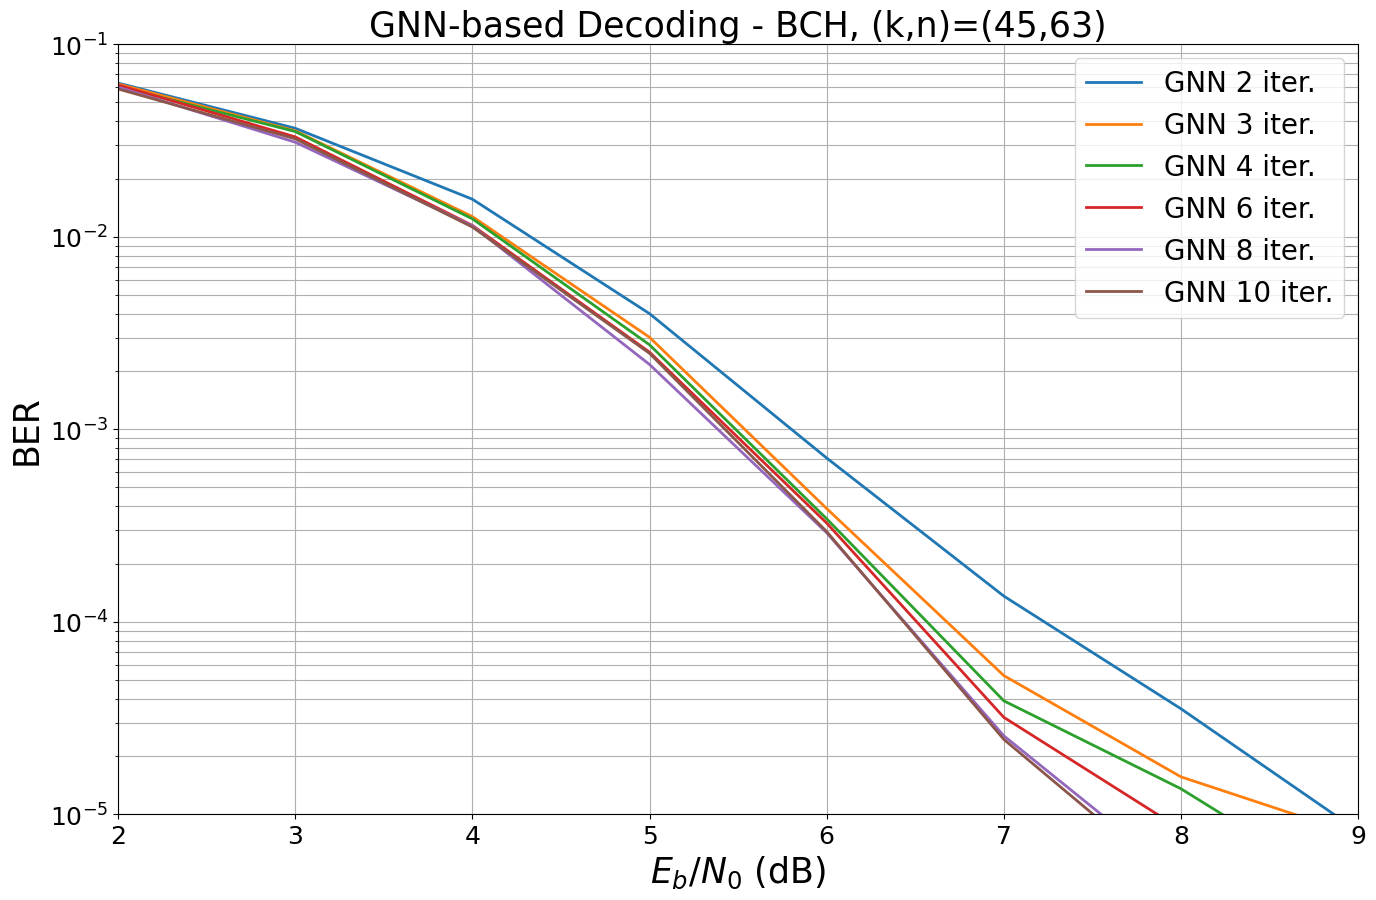

In [9]:
for iters in params["eval_iters"]:
    # instantiate new decoder for each number of iter (otherwise no retracing)
    gnn_dec_temp = GNN_BP(pcm=pcm,
                          num_embed_dims=params["num_embed_dims"],
                          num_msg_dims=params["num_msg_dims"],
                          num_hidden_units=params["num_hidden_units"],
                          num_mlp_layers=params["num_mlp_layers"],
                          num_iter=iters,
                          reduce_op=params["reduce_op"],
                          activation=params["activation"],
                          output_all_iter=False,
                          clip_llr_to=params["clip_llr_to"],
                          use_attributes=params["use_attributes"],
                          node_attribute_dims=params["node_attribute_dims"],
                          msg_attribute_dims=params["msg_attribute_dims"],
                          use_bias=params["use_bias"])    
    # generate new model
    model = E2EModel(encoder, gnn_dec_temp, k, n)
    model(1,1.) # init model
    # copy weights from trained decoder
    model._decoder.set_weights(gnn_decoder.get_weights())

    # and run the BER simulations
    ber_plot.simulate(model,
                     ebno_dbs=ebno_dbs,
                     batch_size=params["mc_batch_size"],
                     num_target_block_errors=500,
                     legend=f"GNN {iters} iter.",
                     soft_estimates=True,
                     max_mc_iter=params["mc_iters"],
                     forward_keyboard_interrupt=False,
                     show_fig=False);

ber_plot(xlim=[2,9],ylim=[1e-5,0.1]) # show final figure

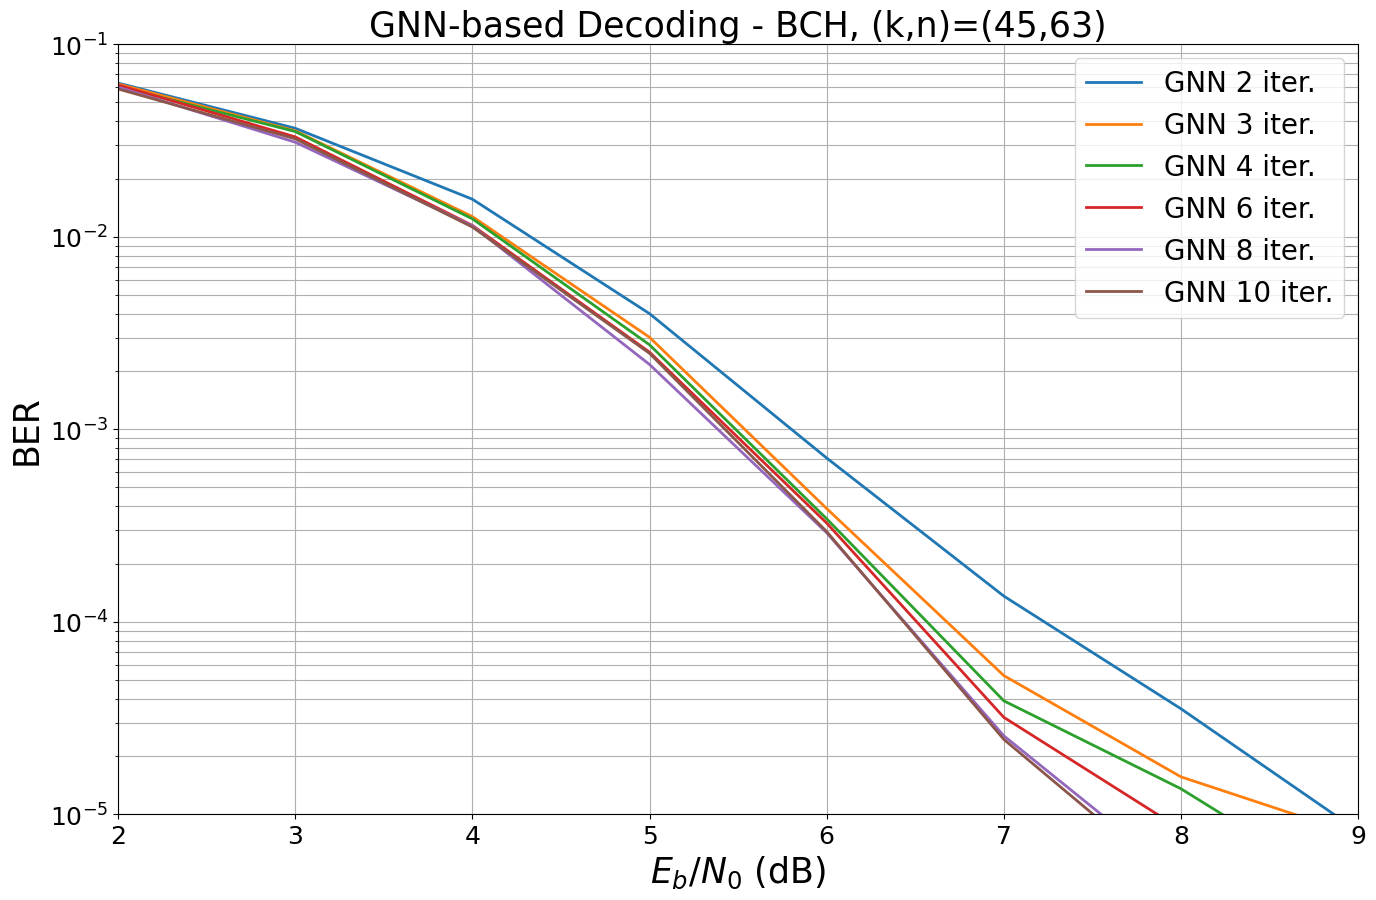

In [14]:
ber_plot(xlim=[2,9],ylim=[1e-5,0.1]) # show final figure

In [ ]:
# export results for pgf plots
col_names = ["uncoded",  "bp-20"]
if params["simulate_wbp"]:
    col_names.append("wbp-20")
for it in params["eval_iters"]:
    col_names.append("gnn-" + str(it))
export_pgf(ber_plot, col_names)

snr, 	uncoded, 	bp-20, 	wbp-20, 	gnn-2, 	gnn-3, 	gnn-4, 	gnn-6, 	gnn-8, 	gnn-10, 	
2.000,	3.807000E-02,	5.990476E-02,	6.537302E-02,	6.427778E-02,	6.301587E-02,	5.967460E-02,	5.848413E-02,	5.702381E-02,	5.632540E-02,	
3.000,	2.266000E-02,	3.210317E-02,	4.306349E-02,	4.035714E-02,	3.753968E-02,	3.586508E-02,	3.038889E-02,	3.017460E-02,	2.681746E-02,	
4.000,	1.243000E-02,	1.442857E-02,	1.862698E-02,	2.052381E-02,	1.605556E-02,	1.300794E-02,	1.076984E-02,	1.015079E-02,	9.162698E-03,	
5.000,	5.845000E-03,	4.821429E-03,	3.666667E-03,	6.468254E-03,	4.575397E-03,	3.182540E-03,	2.438095E-03,	2.064815E-03,	1.965608E-03,	
6.000,	2.322500E-03,	9.013605E-04,	3.574165E-04,	1.607937E-03,	7.293651E-04,	5.446429E-04,	2.872024E-04,	2.162698E-04,	1.642345E-04,	
7.000,	7.687500E-04,	1.482741E-04,	2.587302E-05,	2.746722E-04,	1.043267E-04,	5.368079E-05,	2.163670E-05,	1.467181E-05,	9.946464E-06,	
8.000,	1.961538E-04,	1.234921E-05,	2.523810E-06,	4.011999E-05,	9.612455E-06,	4.793651E-06,	1.492063E-06,	5.634921